Statistical significance
* Whether an experiment yields a result more extreme than what chance might produce, thus is beyond the chance variation, and said to be statistically significant.

P-value
* The probability of obtaining results as unusual or extreme as the observed results

Alpha
* the probability that chance results must surpass for actual outcomes to be deemed statistically significant

Type 1 error
* Concluding an effect is present when it is not

Type 2 error
* Concluding an effect is not present when it is

In [54]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [43]:
df_seed = pd.read_csv('/home/satire/PycharmProjects/Statistics/csv/click_rates.csv')
df = df_seed.pivot(index='Headline', columns='Click', values='Rate')
df

Click,Click,No-click
Headline,,
Headline A,14,986
Headline B,8,992
Headline C,12,988


In [44]:
def perm_fun(x, n_control, n_variant):
    n = n_control + n_variant
    idx_variant = list(random.sample(range(n), n_variant))
    idx_control = list(set(range(n)) - set(idx_variant))
    return x.loc[idx_control].mean() - x.loc[idx_variant].mean()

In [45]:
obs_pct_diff = 100 * (14 / 986 - 8 / 992)
print(f'Observed difference: {obs_pct_diff:.4f}%')

Observed difference: 0.6134%


The number of zeros match the overall sample size minus the total number of successes, which is 1978 items in total (986 + 992) with 22 ones and 1956 zeros.

In [46]:
conversion = [1] * 22 + [0] * (1978 - 22)
conversion = pd.Series(conversion)
perm_diffs = [100 * perm_fun(conversion, 986, 992) for _ in range(1000)]

Text(0, 0.5, 'Frequency')

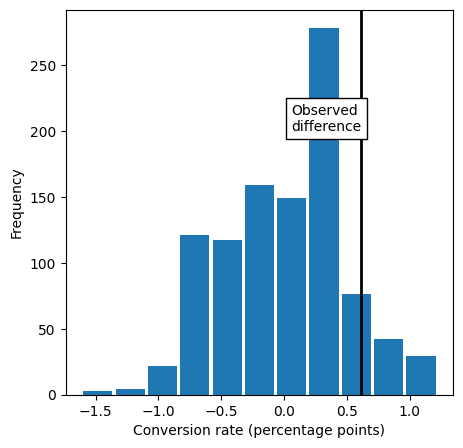

In [47]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor': 'white'})
ax.set_xlabel('Conversion rate (percentage points)')
ax.set_ylabel('Frequency')

In [50]:
p_value = np.mean([diff > obs_pct_diff for diff in perm_diffs])
print(f'P-value: {p_value:.4f}')

P-value: 0.0710


* Estimating the p-value from the permutation test by taking the proportion of times that the permutation test produces a difference equal to or greater than the observed difference.

* Since we have a binomial distribution, we can aproximate the p-value using the chi-squared test

In [56]:
conversions = np.array([[8, 986 - 8], [14, 992 - 14]])
chi2, p_value, df, _ = chi2_contingency(conversions)
print(f'p-value for a single sided test: {p_value / 2:.4f}')

p-value for a single sided test: 0.1451
